# Spleen Segmentation Exercise

In this exercise, we will implement Spleen segmentation using the Medical Decathalon dataset. We'll follow these general steps:  

1. Transforms for dictionary format data.
2. Load Nifti image with metadata.
3. Add channel dim to the data if no channel dimension.
4. Scale medical image intensity with expected range.
5. Crop out a batch of balanced images based on positive / negative label ratio.
6. Cache IO and transforms to accelerate training and validation.
7. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
8. Sliding window inference method.
9. Deterministic training for reproducibility.

Optionally replace the training loop with the Ignite-derived engine classes.

First, we install and import MONAI plug other dependencies.

In [2]:
!python -c "import numpy as np; import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [3]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism, first

print_config()
set_determinism(0)

MONAI version: 0.6.0
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.16.2
Pillow version: 8.3.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
import glob
import os

root_dir="."
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
    
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

set_determinism(seed=0)

## Check data

In [5]:
print(f"#Training: {len(train_files)}")
print(f"#Validation: {len(val_files)}")
print(f"keys: {list(set(data_dicts[0].keys()))}")

#Training: 32
#Validation: 9
keys: ['image', 'label']


## Transformations

Following transformations for validation subset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
2. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
3. `Spacingd` adjusts the spacing by pixdim=(1.5, 1.5, 2.) based on the affine matrix.
4. `Orientationd` unifies the data orientation based on the affine matrix.
5. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
6. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
7. `FgBgToIndices` compute foreground and background from label and return indices.
8. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps

Extra transformations to augment the training subset:
1. `RandCropByPosNegLabeld`randomly crop patch samples from big image based on pos / neg ratio. The image centers of negative samples must be in valid body area.
2. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

Use `ToDeviced` to cache data to GPU to speed up training.

In [60]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandGaussianNoised,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

In [61]:
train_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], 
                 pixdim=(1.5, 1.5, 2.0),
                 mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandGaussianNoised(keys=["image"], prob=0.5),
        EnsureTyped(keys=["image", "label"]),
])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], 
                 pixdim=(1.5, 1.5, 2.0),
                 mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [62]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=10)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=10)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


### Check transforms dataset

Let's display some transformed images.

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


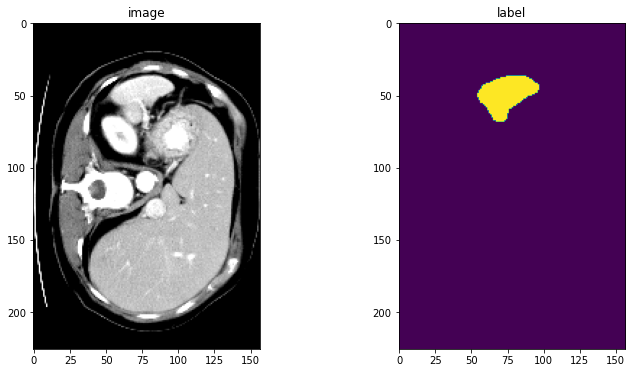

In [63]:
check_data = first(val_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.figure("check val", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


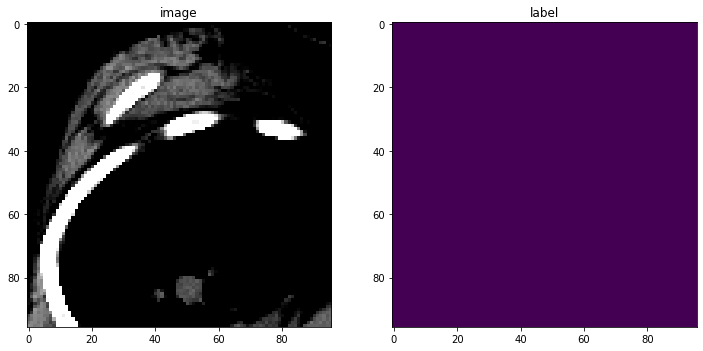

In [64]:
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.figure("check val", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Create Model, Loss, Optimizer

First try - standards:
* Model: Unet
* Loss: DiceLoss
* Optimizer: Adam
* Metric: Dice

In [65]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.optimizers import Novograd

device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# Faster
optimizer = Novograd(model.parameters(), 10 * 2e-4)
scaler = torch.cuda.amp.GradScaler()
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Training

In [66]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 60
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        #outputs = model(inputs)
        #loss = loss_function(outputs, labels)
        #loss.backward()
        #optimizer.step()
        # Faster
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                #val_outputs = sliding_window_inference(
                #    val_inputs, roi_size, sw_batch_size, model)
                # Faster
                with torch.cuda.amp.autocast():
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/60
1/16, train_loss: 0.6306
2/16, train_loss: 0.6282
3/16, train_loss: 0.6147
4/16, train_loss: 0.6269
5/16, train_loss: 0.6019
6/16, train_loss: 0.6136
7/16, train_loss: 0.5962
8/16, train_loss: 0.5900
9/16, train_loss: 0.5890
10/16, train_loss: 0.5672
11/16, train_loss: 0.5342
12/16, train_loss: 0.5655
13/16, train_loss: 0.4936
14/16, train_loss: 0.5272
15/16, train_loss: 0.5244
16/16, train_loss: 0.5104
epoch 1 average loss: 0.5759
----------
epoch 2/60
1/16, train_loss: 0.5165
2/16, train_loss: 0.4998
3/16, train_loss: 0.5287
4/16, train_loss: 0.4835
5/16, train_loss: 0.4798
6/16, train_loss: 0.5221
7/16, train_loss: 0.4816
8/16, train_loss: 0.5160
9/16, train_loss: 0.4384
10/16, train_loss: 0.4417
11/16, train_loss: 0.4220
12/16, train_loss: 0.4368
13/16, train_loss: 0.4860
14/16, train_loss: 0.4821
15/16, train_loss: 0.4419
16/16, train_loss: 0.4343
epoch 2 average loss: 0.4757
saved new best metric model
current epoch: 2 current mean dice: 0.0950
best mean dic

## Plot loss and metric

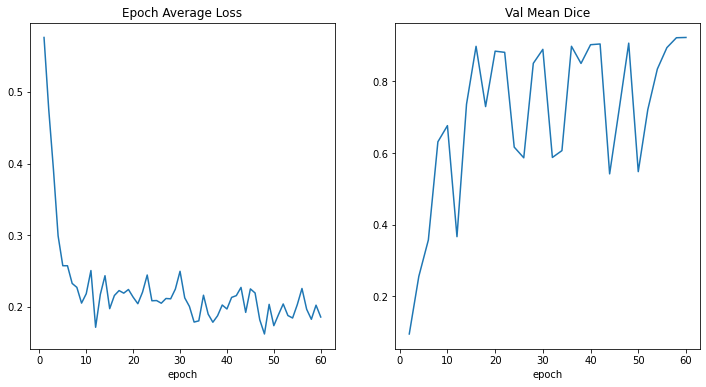

In [67]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Validate the model

Dice score: 0.86814


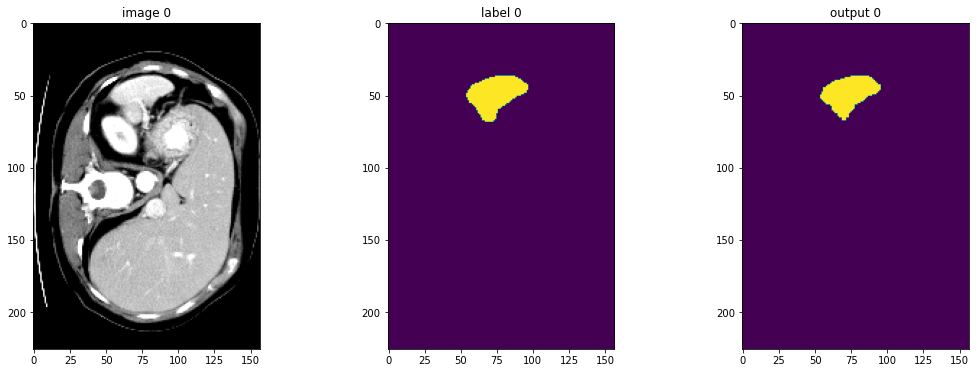

Dice score: 0.94444


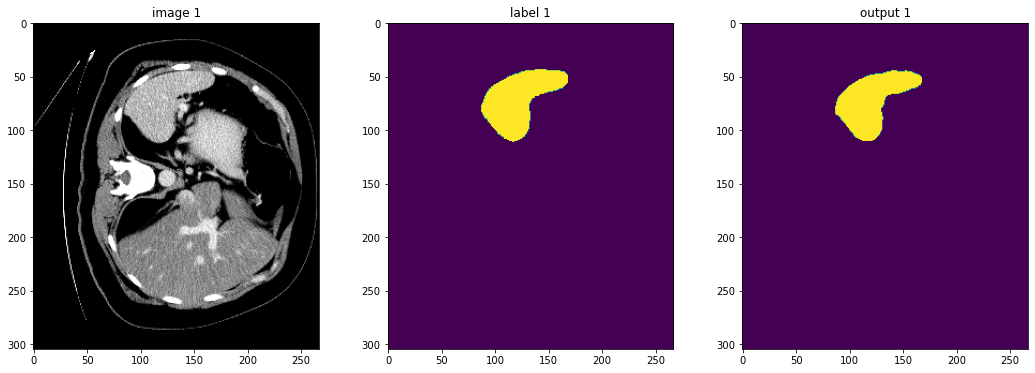

Dice score: 0.94344


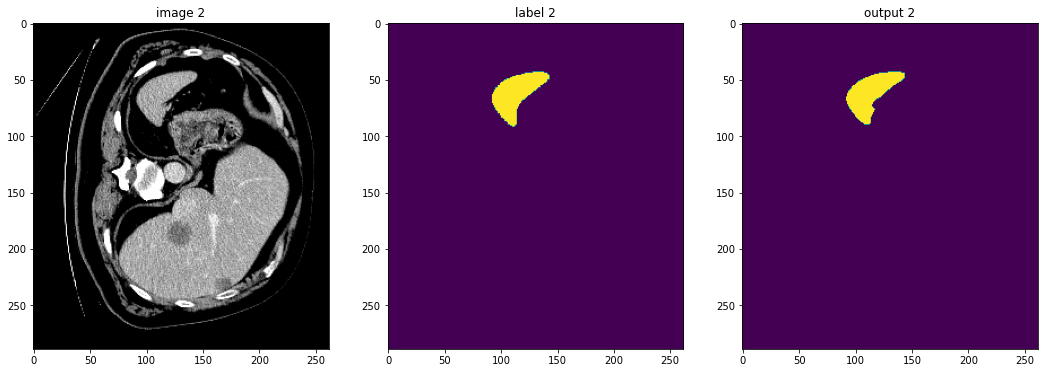

Dice score: 0.94316


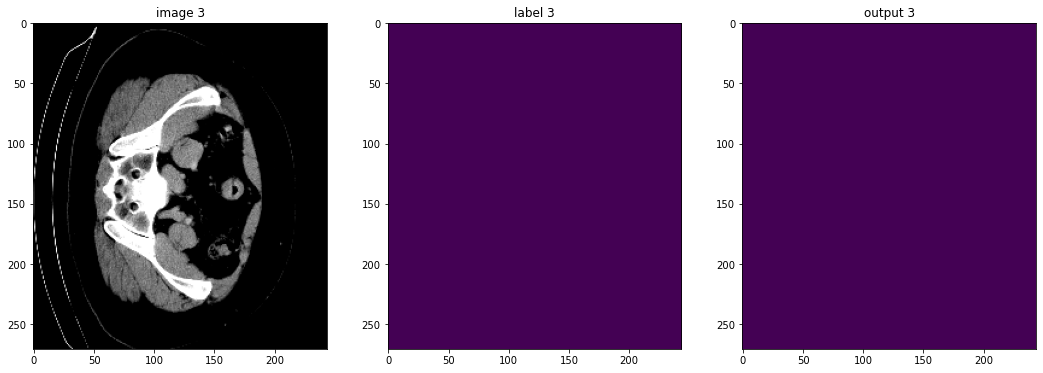

Dice score: 0.87438


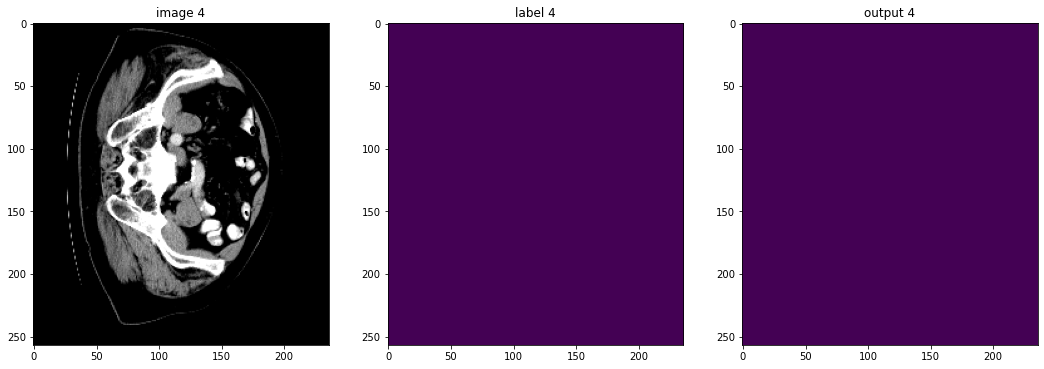

Dice score: 0.93036


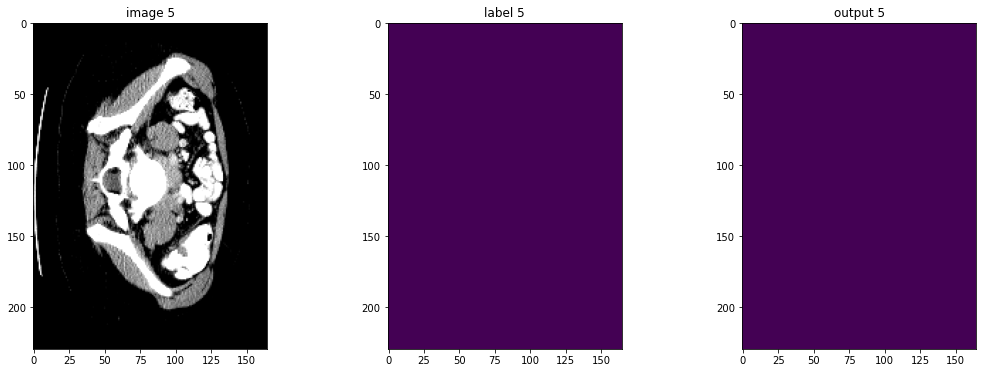

In [69]:
from monai.metrics import compute_meandice
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        val_labels = val_data["label"].detach().cpu()
        val_preds = torch.argmax(val_outputs, dim=1).detach().cpu()[None, ...]
                
        score = compute_meandice(y_pred=val_preds, y=val_labels)
        print(f"Dice score: {score.squeeze():.5f}")
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(val_preds[0, 0, :, :, 80])
        plt.show()
        if i == 5:
            break

## Model performance

In [83]:
post_transforms = Compose([
    EnsureTyped(keys=["pred", "label"]),
    Invertd(
        keys=["pred","label"],
        transform=val_transforms,
        orig_keys="image",
        meta_keys=["pred_meta_dict", "label_meta_dict"],
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, n_classes=2),
    AsDiscreted(keys="label", to_onehot=True, n_classes=2),
])

In [85]:
from monai.handlers.utils import from_engine

model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print(f"Performance on validation set (#{len(val_files)}): ", metric_org)

Performance on validation set (#9):  0.9387729167938232
